In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from collections import defaultdict
import nltk
import string
from nltk.corpus import stopwords
import scipy.stats as ss
from scipy.special import btdtri
plt.style.use('ggplot')

In [174]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\acros\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\acros\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [2]:
%%time
print("Reading in data...")
data = pd.read_csv('train.csv.zip')
print('Done.')

Reading in data...
Done.
Wall time: 4.38 s


In [3]:
data.shape

(1306122, 3)

In [4]:
data.head(10)

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0
5,00004f9a462a357c33be,"Is Gaza slowly becoming Auschwitz, Dachau or T...",0
6,00005059a06ee19e11ad,Why does Quora automatically ban conservative ...,0
7,0000559f875832745e2e,Is it crazy if I wash or wipe my groceries off...,0
8,00005bd3426b2d0c8305,"Is there such a thing as dressing moderately, ...",0
9,00006e6928c5df60eacb,Is it just me or have you ever been in this ph...,0


### Checking the balance of the target label

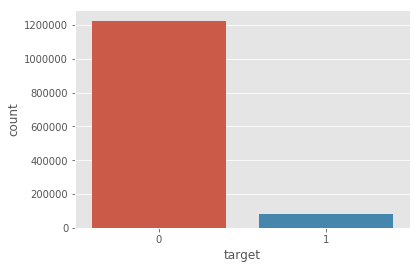

In [5]:
figsize = (10, 7)
sns.countplot(x = 'target', data = data)
plt.show()

In [6]:
#ratio of positive class to negative class
positive_count = len(data[data.target == 1])
negative_count = len(data[data.target == 0])
gc_divisor = math.gcd(negative_count, positive_count) 
positive_count = positive_count / gc_divisor
negative_count = negative_count /gc_divisor

print("The positive to negative label ratio in the training data is %s:%s" % (int(positive_count), int(negative_count)))

The positive to negative label ratio in the training data is 40405:612656


In [60]:
p = data.target.mean()
q = 1 - p
std_error = np.sqrt(p * q / len(data))
std_error = round(std_error, 5)
proportion = round(p, 5)
print("The proportion of positive labels in the training data is %s with standard error %s" % (proportion,  std_error))

The proportion of positive labels in the training data is 0.06187 with standard error 0.00021


In [65]:
lowerConfidence = round(p - 1.96 * std_error, 6)
upperConfidence = round(p + 1.96 * std_error, 6)
print("The 95 percent confidence interval for the mean is (%s, %s)" % (lowerConfidence, upperConfidence))

The 95 percent confidence interval for the mean is (0.061459, 0.062282)


## For fun:
#### It is well known in statistics that normal-theory confidence intervals can be inaccurate for probabilities close to 0 or 1
Our proportion here, from a statistical point of view, can be seen as the probability of a success given some sequence of trials. Or, rather, the probability a comment on Quora is an "insincere comment". 

$p$ is fairly close to 0, so it may be more informative to try a different kind of interval. One common recommendation is the Bayesian Jeffrey's interval.
The prior distribution in this case is the non-informative Jeffrey's prior, which is a Beta distribution with parameters $(1/2, 1/2)$. The plot looks like this:

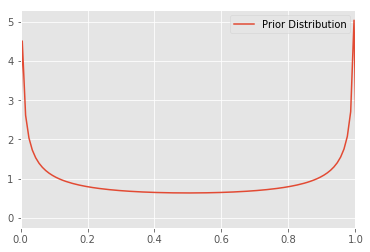

In [122]:
x = np.linspace(-5, 5, 1000)
alpha = 1/2
beta = 1/2
#generate prior distribution and plot it
y = ss.beta.pdf(x, alpha, beta)
plt.xlim((0, 1))
plt.plot(x, y, label='Prior Distribution')
plt.legend();

The posterior distribution is then given as a beta distribution with parameters $( X + 1/2, N - X + 1/2)$, where $X$ is the number of "positive" trials, and $N$ is the number of trials. In our case, $X$ is the number of positive labels and $N$ is the number of data points. This is the Bayesian "updating" in practice.

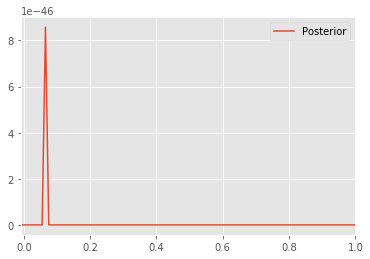

In [130]:
x = np.linspace(-5, 5, 1000)
X = data.target.sum()
N = len(data)
alpha = X + 1/2
beta = N - X + 1/2

y = ss.beta.pdf(x, alpha, beta)
plt.xlim((-0.01, 1))
plt.plot(x, y, label='Posterior')
plt.legend();

The density is centered in one point, because we have a large amount of data, so the posterior distribution becomes quite precise. The prior we used is non-informative, and so lets the data speak for itself. The 95% credible interval is now the interval that consists of the 2.5% and 97.5% quantiles of the distribution. It is computed with the `beta.ppf()` in Python.

In [120]:
#95% credible interval
ss.beta.ppf([0.025, 0.975], alpha, beta)

array([0.06145798, 0.06228432])

We get nearly the same result. This is intuitive, as we have over a million data points!

##### We can see that less than 10% of the data consists of positive labels
However, more than 5% of the data consists of positive labels. We could say our data set is moderately imbalanced, thus classifiers should likely account for this imbalance, assuming a similar distribution in the test set. Note that accuracy would be a poor metric of performance here, since predicting all labels to be negative will achieve over 90% accuracy.

Now do we have any duplicate qustions?

In [8]:
# number of unique question IDs
data.qid.nunique()

1306122

In [9]:
#number of data points
len(data)

1306122

### There appear to be no duplicate questions

Let's now look at some statistics related to the questions themselves. We'll show with and without removed stop words.

In [269]:
wordCount = defaultdict(int)
punctuation = set(string.punctuation)
def word_counter(d):
    r = ''.join([c for c in d.lower() if not c in punctuation])
    for w in r.split():
        #w = stemmer.stem(w) # with stemming
        wordCount[w] += 1

data.question_text.apply(word_counter)
print(len(wordCount))

258289


In [270]:
#compute the mean and standard errors for the word frequency
word_frequencies = np.asarray(list(wordCount.values()))
mean_frequency = round(word_frequencies.mean(), 3)

std_dev = round(np.std(word_frequencies), 3)

std_error = round(std_dev / np.sqrt( len(word_frequencies)), 3)
print("The mean word frequency is %s, with standard devation %s, standard error %s" %
     (mean_frequency, std_dev, std_error))

The mean word frequency is 64.673, with standard devation 2898.658, standard error 5.704


In [271]:
lowerConfidence = mean_frequency - 1.96 * std_error
upperConfidence = mean_frequency + 1.96 * std_error
print("The 95 percent confidence interval is (%s, %s)" % (lowerConfidence, upperConfidence))

The 95 percent confidence interval is (53.49316, 75.85284)


What does the distribution look like?

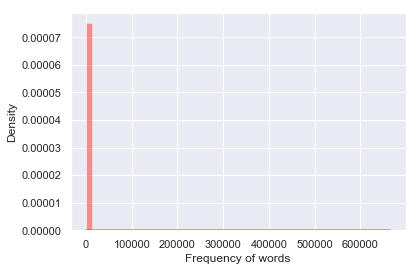

In [281]:
sns.distplot(word_frequencies, color = 'red')
plt.xlabel('Frequency of words')
plt.ylabel('Density')
plt.show()

The x-axis corresponds to the word frequencies in our data, the y-axis is a relative measure of density. (Higher bars = that particular frequency was more common)
The word frequencies are extremely skewed, which is why the plot looks weird.

In [282]:
word_frequencies.max()

665465

In [283]:
word_frequencies.min()

1

In [284]:
len(word_frequencies[word_frequencies >= 1000])

1638

The minimum frequency of a word is 1, the maximum is nearly 700,000. This is an extreme range, which is why the standard deviation was so high. Moreover, less than 2000 words actually show up more than 1000 times across all quora comments. These must be very common words used in every day speech.

We can trim the data and see if we can get a more sensible plot. Let's stick to frequencies a little closer to the mean.

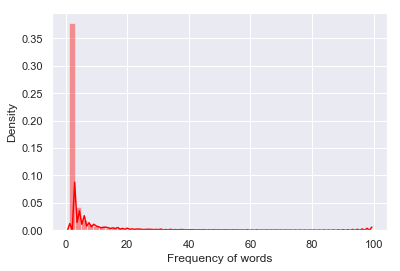

In [296]:
sns.distplot(word_frequencies[word_frequencies < 100], color = 'red')
plt.xlabel('Frequency of words')
plt.ylabel('Density')
plt.show()

Still extremely skewed. The vast majority of words in our dictionary appear less than 20 times across. That means each quora comment uses some vocabulary that none of the rest share. That can be useful, however it could *potentially* hurt any model's generalization. Since the words appear so infrequently, there may be no other quora comments with the same words in the test set. We should think carefully about what to do with words like this.

Let's try trimming again.

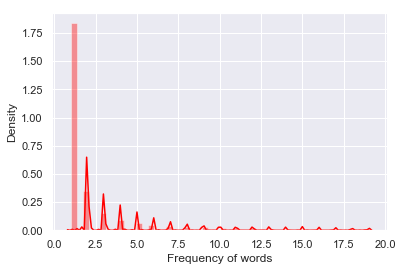

In [292]:
sns.distplot(word_frequencies[word_frequencies < 20], color = 'red')
plt.xlabel('Frequency of words')
plt.ylabel('Density')
plt.show()

Lots of little peaks in the distribution. This is mostly because our frequencies are round integers, so there is "space" in between the bars. What if we trim the lower end now?

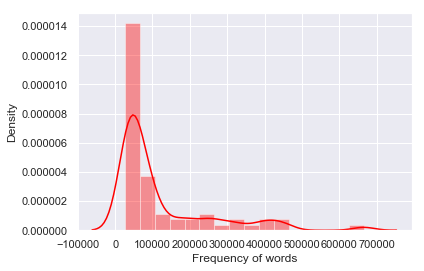

In [295]:
sns.distplot(word_frequencies[word_frequencies >= 25000], color = 'red')
plt.xlabel('Frequency of words')
plt.ylabel('Density')
plt.show()

While this is more reasonable, we still have a similar looking distribution. It looks to me that the distribution of the word counts is a heavily scaled version of the exponential distribution, plotted below.

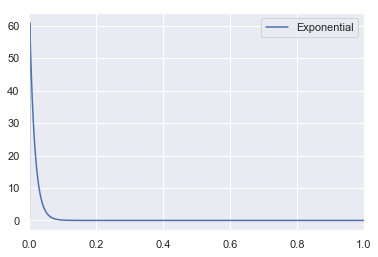

In [316]:
x = np.linspace(-1, 5, 5000)
y = ss.expon.pdf(x, scale = 1/65)
plt.xlim((-0.001, 1))
plt.plot(x, y, label='Exponential')
plt.legend();

### What are the 20 most popular words?

In [317]:
counts = [(wordCount[w], w) for w in wordCount]
counts.sort()
counts.reverse()

words = [x[1] for x in counts[:1000]]
words[0:20]

['the',
 'what',
 'is',
 'a',
 'to',
 'in',
 'of',
 'i',
 'how',
 'and',
 'do',
 'are',
 'for',
 'you',
 'can',
 'why',
 'it',
 'my',
 'that',
 'if']

### The smost popular words all look like stop words.
Lets remove those and try again.

In [339]:
wordCount = defaultdict(int)
punctuation = set(string.punctuation)
#load in stop words
stopwordz = set(stopwords.words('english'))
#define a function to be used with apply
def word_counter(d):
    #first remove punctuation, then remove stop words
    r = ''.join([c for c in d.lower() if not c in punctuation])
    j = ' '.join([c for c in r.split() if not c in stopwordz])
    for w in j.split():
        #w = stemmer.stem(w) # with stemming
        wordCount[w] += 1

#use .apply to iterate over dataframe
data.question_text.apply(word_counter)
print(len(wordCount))

258142


######  We can now look at the new list of the 20 most popular words

In [340]:
counts = [(wordCount[w], w) for w in wordCount]
counts.sort()
counts.reverse()

words = [x[1] for x in counts[:1000]]
words[0:20]

['get',
 'best',
 'would',
 'people',
 'like',
 'good',
 'one',
 'india',
 'make',
 'think',
 'many',
 'much',
 'time',
 'life',
 'someone',
 'use',
 'way',
 'know',
 'us',
 'want']

#### How has the mean and standard errors changed?

In [341]:
#compute the mean and standard errors for the word frequency
word_frequencies = np.asarray(list(wordCount.values()))
mean_frequency = round(word_frequencies.mean(), 3)

std_dev = round(np.std(word_frequencies), 3)

std_error = round(std_dev / np.sqrt( len(word_frequencies)), 3)
print("The mean word frequency is %s, with standard devation %s, standard error %s" %
     (mean_frequency, std_dev, std_error))

The mean word frequency is 33.007, with standard devation 442.35, standard error 0.871


In [342]:
lowerConfidence = round(mean_frequency - 1.96 * std_error, 6)
upperConfidence = round(mean_frequency + 1.96 * std_error, 6)
print("The 95 percent confidence interval is (%s, %s)" % (lowerConfidence, upperConfidence))

The 95 percent confidence interval is (31.29984, 34.71416)


#### So we can see that the mean frequency and standard deviation/errors have shrunk a lot
This makes sense. We have removed stopwords which would appear in nearly every quora question. Since they appear so frequently, their frequency is very high, and would drag the mean and standard deviations up considerably. What if we use a trimmed mean in order to get rid of some outliers?

In [358]:
ss.trim_mean(word_frequencies, proportiontocut = 0.025)

6.295070870508408

Slicing 2.5% from the lower half, and 2.5% from the upper half of the data results in a very different mean. There are not too many words with that high of a frequency. That means there are likely some words used very commonly in english, but the rest of the words are likely descriptors used for the actual formulation of the question

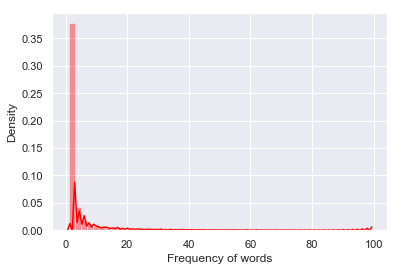

In [344]:
sns.distplot(word_frequencies[word_frequencies < 100], color = 'red')
plt.xlabel('Frequency of words')
plt.ylabel('Density')
plt.show()

The distribution of frequencies under 100 looks about the same. Makes sense since removing stop words shouldn't affect rare words. What about the other side?

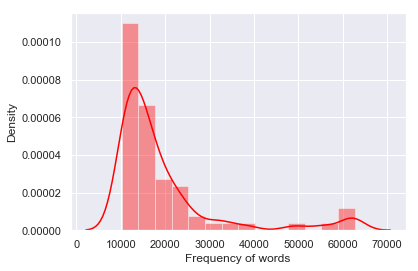

In [346]:
sns.distplot(word_frequencies[word_frequencies >= 10000], color = 'red')
plt.xlabel('Frequency of words')
plt.ylabel('Density')
plt.show()

Looks like the upper tail of the distribution has changed! So removing stopped words has changed the distribution of the upper tail of the word frequencies. What's the distribution of the frequencies with the upper and lower tails removed?

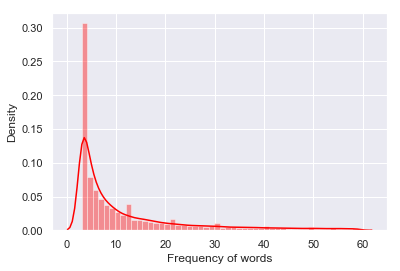

In [373]:
sns.distplot(word_frequencies[(2 < word_frequencies) & (word_frequencies < 60)], color = 'red')
plt.xlabel('Frequency of words')
plt.ylabel('Density')
plt.show()

Looks almost exactly like an exponential distribution. What are the bottom tail words, anyway?

In [352]:
counts[258118: 258142]

[(1, '00002cm'),
 (1, '00002673'),
 (1, '00002'),
 (1, '0000125'),
 (1, '0000036'),
 (1, '0000032099'),
 (1, '00000218'),
 (1, '000001cm'),
 (1, '00000100'),
 (1, '000001'),
 (1, '0000001'),
 (1, '000000030'),
 (1, '00000000010009999560'),
 (1, '0000000000001'),
 (1, '00000000000000025'),
 (1, '00000000000000000021e800'),
 (1, '000000000000000000000000000000000000000000125'),
 (1, '000000000000000000000000000'),
 (1, '0000000000'),
 (1, '000000'),
 (1, '0\x02tñ\x7f¼é\x1aaùõ\x8d¶rwìiìñó'),
 (1, '\x10œø\x17'),
 (1, '\x10new'),
 (1, '\x10i')]

These look like gibberish and are probably not useful.

Let's look at the most popular words in the sincere questions and the insincere questions.

First, the insincere questions.

In [377]:
badCount = defaultdict(int)
punctuation = set(string.punctuation)
#load in stop words
stopwordz = set(stopwords.words('english'))
#define a function to be used with apply
def word_counter(d):
    #first remove punctuation, then remove stop words
    r = ''.join([c for c in d.lower() if not c in punctuation])
    j = ' '.join([c for c in r.split() if not c in stopwordz])
    for w in j.split():
        #w = stemmer.stem(w) # with stemming
        badCount[w] += 1

#use .apply to iterate over dataframe
data[data.target == 1].question_text.apply(word_counter)
print(len(badCount))

45321


In [378]:
counts = [(badCount[w], w) for w in badCount]
counts.sort()
counts.reverse()

badwords = [x[1] for x in counts[:1000]]
badwords[0:50]

['people',
 'like',
 'trump',
 'women',
 'would',
 'men',
 'think',
 'white',
 'many',
 'muslims',
 'dont',
 'quora',
 'us',
 'get',
 'india',
 'indian',
 'black',
 'americans',
 'sex',
 'girls',
 'indians',
 'want',
 'world',
 'hate',
 'liberals',
 'chinese',
 'much',
 'make',
 'muslim',
 'country',
 'even',
 'american',
 'one',
 'feel',
 'america',
 'know',
 'president',
 'believe',
 'donald',
 'true',
 'say',
 'really',
 'jews',
 'gay',
 'good',
 'countries',
 'questions',
 'still',
 'cant',
 'democrats']

Now the sincere questions

In [379]:
goodCount = defaultdict(int)
punctuation = set(string.punctuation)
#load in stop words
stopwordz = set(stopwords.words('english'))
#define a function to be used with apply
def word_counter(d):
    #first remove punctuation, then remove stop words
    r = ''.join([c for c in d.lower() if not c in punctuation])
    j = ' '.join([c for c in r.split() if not c in stopwordz])
    for w in j.split():
        #w = stemmer.stem(w) # with stemming
        goodCount[w] += 1

#use .apply to iterate over dataframe
data[data.target == 0].question_text.apply(word_counter)
print(len(goodCount))

246881


In [380]:
counts = [(goodCount[w], w) for w in goodCount]
counts.sort()
counts.reverse()

goodwords = [x[1] for x in counts[:1000]]
goodwords[0:50]

['best',
 'get',
 'would',
 'like',
 'people',
 'good',
 'one',
 'india',
 'make',
 'time',
 'think',
 'much',
 'life',
 'someone',
 'many',
 'use',
 'way',
 'know',
 'work',
 'take',
 'ever',
 'find',
 'us',
 'want',
 'become',
 'without',
 'could',
 'person',
 'better',
 'feel',
 'world',
 'year',
 'possible',
 'whats',
 'job',
 'go',
 'new',
 'dont',
 'im',
 'years',
 'mean',
 'used',
 'start',
 'need',
 'difference',
 'quora',
 'first',
 'different',
 'money',
 'learn']

The difference is pretty clear. Insincere reviews' most popular words largely are concerned with groups of people, either their ethnicities, religion, or political affiliations. The sincere reviews are more ambiguous, but do include some positives, such as "learn", "think", "best", "good".

#### Opinion: One possible approach would be to train a classifier on *just* words the negative reviews, since it might be easier to fish out the most popular words that are associated with the target label.
However, this approach needs some care. The correct procedure would be to seperate our data into train and validation splits FIRST, *then* compute the most popular bad words on only the train split, and train the model on those features. This will give us a more accurate estimate of generalization performance than if we extracted the features BEFORE the split. (It's often called "data leakage").

What about bigrams, real quick?

In [381]:
badCount = defaultdict(int)
punctuation = set(string.punctuation)
#load in stop words
stopwordz = set(stopwords.words('english'))
#define a function to be used with apply

def bigram_counter(d):
    #first remove punctuation, then remove stop words
    n = 2
    r = ''.join([c for c in d.lower() if not c in punctuation])
    j = ' '.join([c for c in r.split() if not c in stopwordz])
    for w in nltk.ngrams(j.split(), n):
        #w = stemmer.stem(w) # with stemming
        badCount[w] += 1

#use .apply to iterate over dataframe
data[data.target == 1].question_text.apply(bigram_counter)
print(len(badCount))

C:\Users\acros\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: generator 'ngrams' raised StopIteration
  if sys.path[0] == '':


453080


In [383]:
counts = [(badCount[w], w) for w in badCount]
counts.sort()
counts.reverse()

badwords = [x[1] for x in counts[:1000]]
badwords[0:50]

[('donald', 'trump'),
 ('white', 'people'),
 ('black', 'people'),
 ('united', 'states'),
 ('president', 'trump'),
 ('trump', 'supporters'),
 ('many', 'people'),
 ('hillary', 'clinton'),
 ('year', 'old'),
 ('even', 'though'),
 ('people', 'think'),
 ('chinese', 'people'),
 ('indian', 'muslims'),
 ('indian', 'girls'),
 ('north', 'korea'),
 ('north', 'indians'),
 ('white', 'women'),
 ('white', 'men'),
 ('people', 'hate'),
 ('black', 'men'),
 ('look', 'like'),
 ('people', 'quora'),
 ('gun', 'control'),
 ('people', 'like'),
 ('south', 'indians'),
 ('indian', 'women'),
 ('women', 'like'),
 ('indian', 'men'),
 ('middle', 'east'),
 ('narendra', 'modi'),
 ('questions', 'quora'),
 ('years', 'old'),
 ('people', 'say'),
 ('african', 'americans'),
 ('would', 'happen'),
 ('black', 'women'),
 ('dont', 'like'),
 ('indian', 'people'),
 ('dont', 'want'),
 ('illegal', 'immigrants'),
 ('feel', 'like'),
 ('gay', 'people'),
 ('people', 'believe'),
 ('american', 'people'),
 ('act', 'like'),
 ('men', 'women'),

Looks about how I expected. How about $n$grams when $n = 5$?

In [385]:
badCount = defaultdict(int)
punctuation = set(string.punctuation)
#load in stop words
stopwordz = set(stopwords.words('english'))
#define a function to be used with apply

def bigram_counter(d):
    #first remove punctuation, then remove stop words
    n = 5
    r = ''.join([c for c in d.lower() if not c in punctuation])
    j = ' '.join([c for c in r.split() if not c in stopwordz])
    for w in nltk.ngrams(j.split(), n):
        #w = stemmer.stem(w) # with stemming
        badCount[w] += 1

#use .apply to iterate over dataframe
data[data.target == 1].question_text.apply(bigram_counter)

counts = [(badCount[w], w) for w in badCount]
counts.sort()
counts.reverse()

badwords = [x[1] for x in counts[:1000]]
badwords[0:50]

C:\Users\acros\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: generator 'ngrams' raised StopIteration
  if sys.path[0] == '':


[('ever', 'deny', 'causing', 'black', 'death'),
 ('jew', 'ever', 'deny', 'causing', 'black'),
 ('testicles', 'replaced', 'testicles', 'another', 'animal'),
 ('like', 'iraq', 'first', 'world', 'country'),
 ('human', 'female', 'female', 'species', 'testicles'),
 ('female', 'female', 'species', 'testicles', 'came'),
 ('would', 'happen', 'castrated', 'remove', 'testicles'),
 ('swedish', 'women', 'think', 'ethnic', 'swedes'),
 ('remove', 'testicles', 'replaced', 'testicles', 'another'),
 ('happen', 'castrated', 'remove', 'testicles', 'replaced'),
 ('castrated', 'remove', 'testicles', 'replaced', 'testicles'),
 ('people', 'say', 'bullies', 'jealous', 'victim'),
 ('freedom', 'shooting', 'people', 'walking', 'streets'),
 ('would', 'prefer', 'hear', 'rather', 'reason'),
 ('victims', 'wells', 'finally', 'kill', 'victims'),
 ('victims', 'throw', 'victims', 'wells', 'finally'),
 ('victims', 'shoot', 'victims', 'throw', 'victims'),
 ('ugly', 'face', 'makes', 'stand', 'much'),
 ('throw', 'victims', 

# Jesus christ.